# Feature Engineering e Feature Selection
O objetivo deste notebook é criar variáveis que possam ter impacto no modelo, assim como filtrar e remover aquelas que não demonstram importância

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import shuffle
from collections import Counter

# Dataset

In [2]:
train_set = pd.read_csv('./../dados_processados/train_sample.csv')
test_set = pd.read_csv('./../dados_processados/test_sample.csv')

In [3]:
info_bairro = pd.read_csv('./../dados_processados/neighbourhood_info.csv')

In [4]:
train_set = train_set.merge(info_bairro)
test_set = test_set.merge(info_bairro)

train_set.drop(['neighbourhood_cleansed'],axis=1,inplace=True)
test_set.drop(['neighbourhood_cleansed'],axis=1,inplace=True)

## Imputação
Utilizei o valor mediano de cada variável como método de imputação 

Novamente, é desejável utilizar os dados do conjunto de treinamento para fazer qualquer processamento do conjunto de teste

In [5]:
for c in train_set.columns:
    # Método de imputação: Mediana
    imputer = train_set[c].median()
    # Utilizo a mediana do conjunto de treinamento 
    # para imputar no conjunto de teste
    train_set[c] = train_set[c].fillna(imputer)
    test_set[c] = test_set[c].fillna(imputer)

## Remove variáveis com baixo nível de variância.
Assim, conseguimos manter apenas features com informação à agregar

In [6]:
var_sel = VarianceThreshold(threshold=0.1).fit(train_set)

# Obtem as variaveis pós filtro de variancia
filtered_columns = var_sel.get_support()

train_data = train_set.loc[:,filtered_columns]
test_data = test_set.loc[:,filtered_columns]

## Salva as features selecionadas para o modelo

In [7]:
model_features = train_data.columns

with open('./../dados_processados/model_features.pkl','wb') as f:
    pickle.dump(model_features,f)

# Análise Exploratória das Variáveis

host_is_superhost


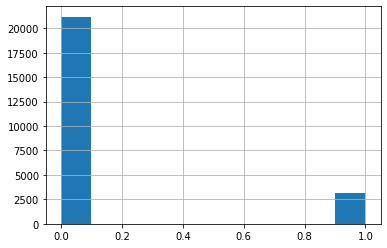

host_listings_count


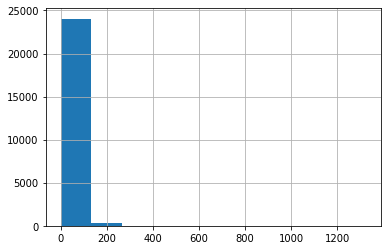

host_total_listings_count


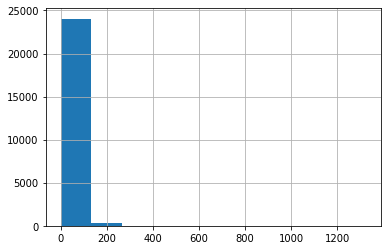

accommodates


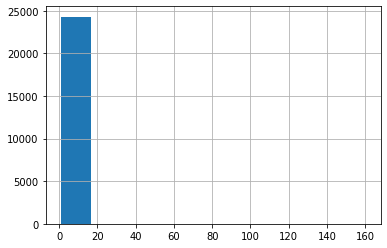

bathrooms


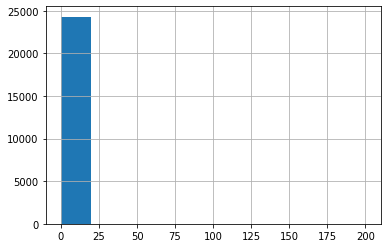

bedrooms


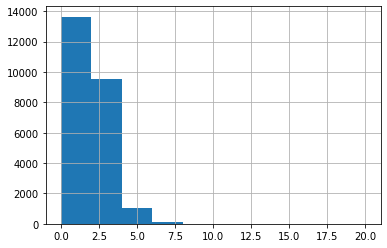

beds


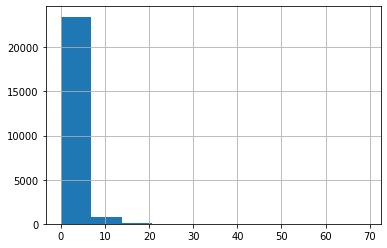

price


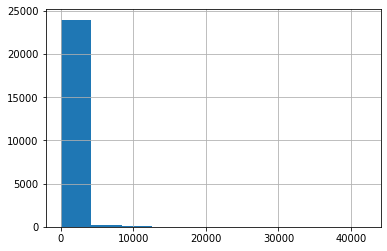

guests_included


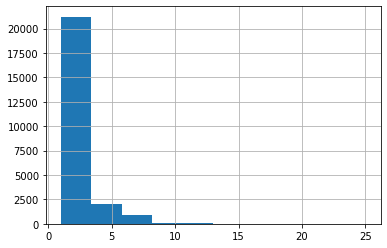

minimum_nights


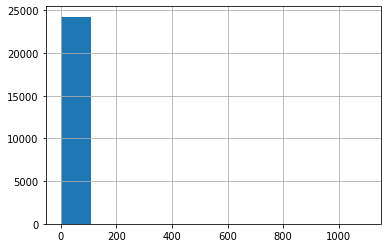

maximum_nights


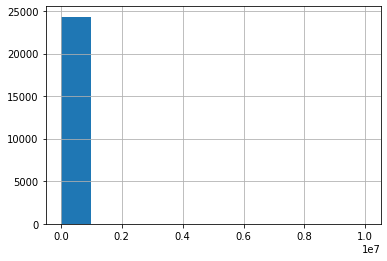

minimum_minimum_nights


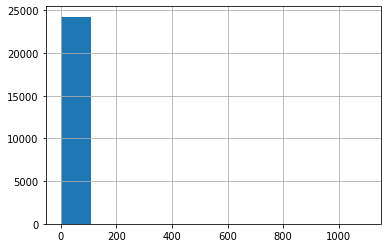

maximum_minimum_nights


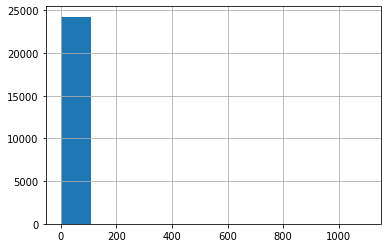

minimum_maximum_nights


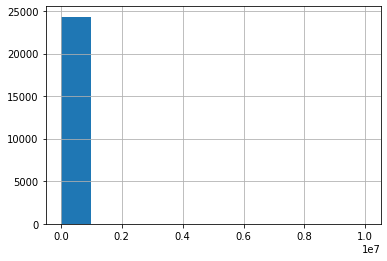

maximum_maximum_nights


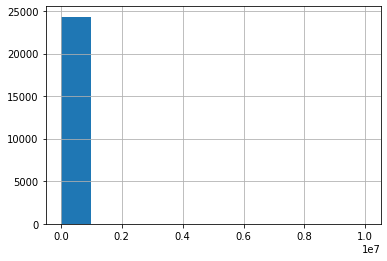

minimum_nights_avg_ntm


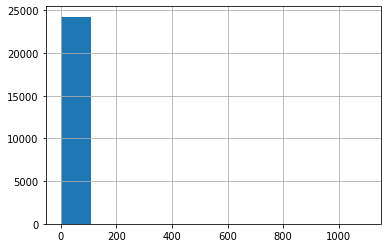

maximum_nights_avg_ntm


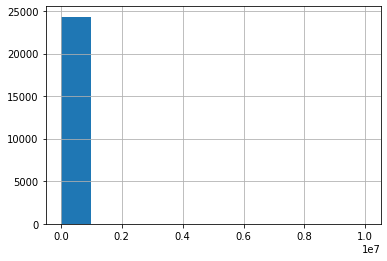

number_of_reviews


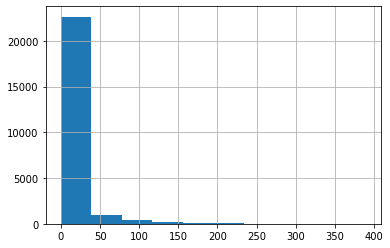

number_of_reviews_ltm


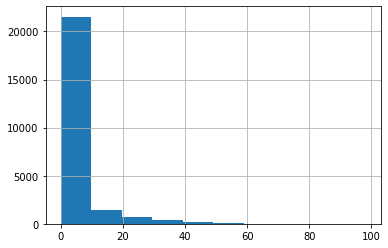

calculated_host_listings_count


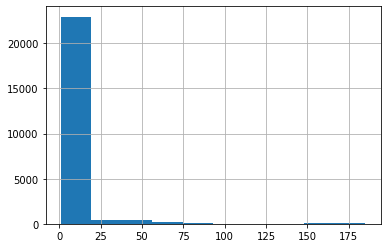

calculated_host_listings_count_entire_homes


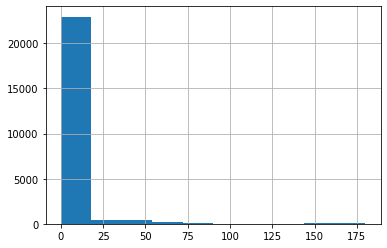

calculated_host_listings_count_private_rooms


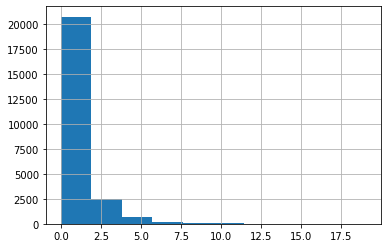

calculated_host_listings_count_shared_rooms


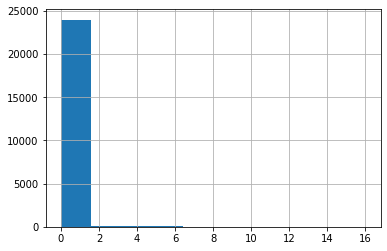

cancellation_policy_moderate


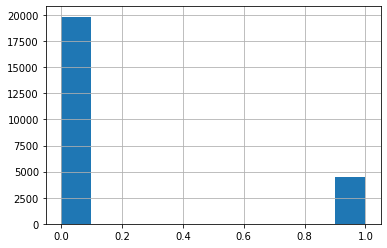

neighbourhood_mean_price


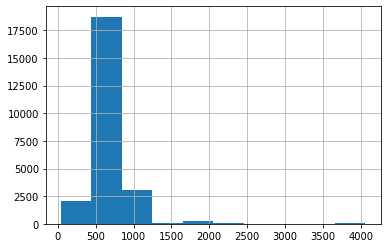

In [8]:
colunas_com_outliers = []
for c in train_data.columns:
    IQR = np.quantile(train_data[c],0.75) - np.quantile(train_data[c],0.25)
    mask = train_data[c] > np.quantile(train_data[c],0.75) + 2.5*IQR
    if train_data[mask].shape[0] > 0:
        colunas_com_outliers.append(c)
        print(c)
        train_data[c].hist()
        plt.show()

A distribuição do preço é muito assimétrica e com vários outliers. Faremos o tratamento dela separadamente

## Limitando outliers
Aqui aplicamos um limite superior nos outliers para que sejam no máximo o 3o quartil mais 2.5 vezes o Inter Quartile Range (IQR)

In [9]:
colunas_nao_mexer = [
    'price',
    'host_is_superhost',
    'calculated_host_listings_count_shared_rooms',
    'cancellation_policy_moderate'
]

for c in colunas_nao_mexer:
    colunas_com_outliers.remove(c)

# Aplicacao do limite
for c in colunas_com_outliers:
    IQR = np.quantile(train_data[c],0.75) - np.quantile(train_data[c],0.25)
    mask = train_data[c] > np.quantile(train_data[c],0.75) + 2.5*IQR
    train_data.loc[mask,c] = np.quantile(train_data[c],0.75) + 2.5*IQR

C:\Users\henri\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Salva os dados processados

In [10]:
train_data.to_csv('./../dados_processados/train_dataset.csv',index=False)
test_data.to_csv('./../dados_processados/test_dataset.csv',index=False)

## Correlação das variáveis com o preço

In [11]:
# Maiores correlações em valores absolutos
train_data.corrwith(train_data['price']).abs().sort_values().tail(10)

number_of_reviews           0.131399
number_of_reviews_ltm       0.131995
Hot water                   0.133787
Free parking on premises    0.150764
neighbourhood_mean_price    0.167000
beds                        0.223119
accommodates                0.274324
bedrooms                    0.305768
bathrooms                   0.321720
price                       1.000000
dtype: float64

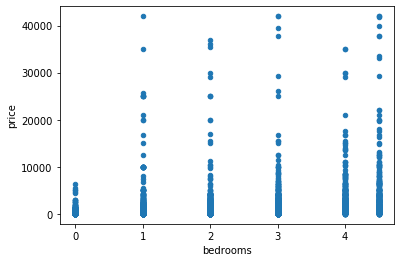

In [12]:
train_data.plot(kind='scatter',
                 x='bedrooms',
                 y='price')
plt.show()

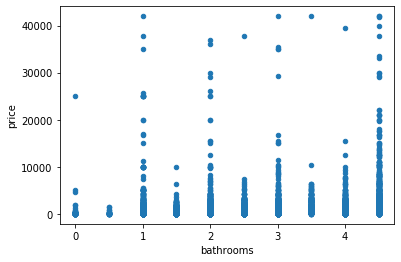

In [13]:
train_data.plot(kind='scatter',
                 x='bathrooms',
                 y='price')
plt.show()

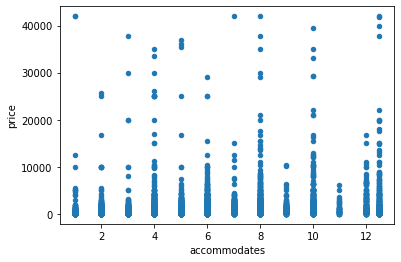

In [14]:
train_data.plot(kind='scatter',
                 x='accommodates',
                 y='price')
plt.show()

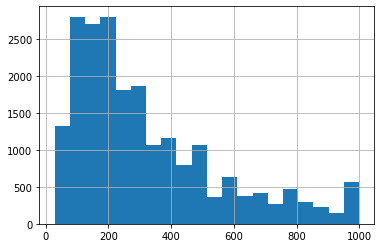

In [15]:
train_data[train_data['price']<1000]['price'].hist(bins=20)